# Solving Laplace's equation using the relaxation method

## An Example in 2D

To illustrate the numerical approach, we will consider the same problem as Example 3.4 in the textbook.

Two infinitely-long grounded metal plates at y = 0 and y = a, are connected at $x = \pm b$ by metal strips maintained at a constant potential $V_0$ (a thin layer of insulation at each corner prevents them from shorting out). Find the potential inside the resulting rectangular pipe.

This is a 2D problem, and the equation we need to solve is the Laplace's equation
$$\frac{\partial^2 V}{\partial x^2}+\frac{\partial^2 V}{\partial y^2}=0,$$
with the boundary conditions
$$V(x,y=0)=0,$$
$$V(x,y=a)=0,$$
$$V(x=-b,y)=V_0,$$
$$V(x=b,y)=V_0.$$

To numerically solve the problem, we will use the *finite-difference method*. We set up a grid on the domain, with cell size $\Delta x=\Delta y=\Delta$. We will obtain the numerical value of the solution at each of the grid points. Let $V_{i,j}$ be the value of $V$ at the grid point that is the i-th in the x direction and the j-th in the y direction.  

Laplace's equation can be solved using the *relaxation method*. The basic idea is the following. Let's write the Laplace's equation as $$\mathcal{L} V=0.$$ 
If we consider the following diffusion problem 
$$\frac{\partial V}{\partial t}=\mathcal{L}V,$$
we find that an initial distribution V relaxes to an equilibrium solution as $t\to\infty$. This equilibrium has all time derivatives vanishing. Therefore it is the solution of the original Laplace's equation.

We can represent the diffusion equation on our discretized grid using a finite difference scheme as follows: 
$$\frac{V_{i,j}^{n+1}-V_{i,j}^n}{\Delta t}=\frac{V_{i-1,j}^n+V_{i+1,j}^n-2V_{i,j}^n}{\Delta^2}+\frac{V_{i,j-1}^n+V_{i,j+1}^n-2V_{i,j}^n}{\Delta^2},$$
where the superscripts $n$ and $n+1$ denote the values at time step $n$ and $n+1$, respectively, and $\Delta t$ is the time step size.  On the left hand side, this is just an approximation of the time derivative that is first order in $\Delta t$. On the right hand side, we have approximations to the spatial derivatives that are second order in the grid spacing $\Delta$. This scheme is stable as long as $\Delta t/\Delta^2\le1/4$ in two dimensions. Taking the maximum possible step size, $\Delta t=(1/4)\Delta^2$, we have
$$V_{i,j}^{n+1}=\frac{1}{4}(V_{i-1,j}^n+V_{i+1,j}^n+V_{i,j-1}^n+V_{i,j+1}^n).\qquad (*)$$
Namely, at each time step, we replace the value of V at each grid point using the average of V at its four nearest-neighbor points on the grid. This procedure is then iterated until convergence.

This procedure is easier to understand if we recall the properties of the solution to Laplace's equation: in 2D we know that the value of V at a point $(x,y)$ is the average of those around the point, in particular
$$V(x,y)=\frac{1}{2\pi R}\oint\limits_{\rm circle} V\,dl.$$
If we start with an initial guess for V that does not satisfy this relation, we can iterate using Equation (*) by setting the value at each grid point to be the average of its nearest neighbors. Doing just once is not enough: imagine that you have fixed one point using old neighboring values, but the neighbors themselves will be updated too, which changes the relation again. So we need to carry out many iterations until all settles.

This is the simplest relaxation method called Jacobi's method. More advanced relaxation methods with faster convergence rate can be found in e.g., Press et al 1999, *Numerical Recipes in C*. There are also other modern methods for solving Laplace's equation, the most popular one being the finite element method. This typically works on a triangulated mesh. In most applications, it is usually the irregular domain of interest that poses the biggest challenge. A triangulated mesh can easily conform to the arbitrary domain shape, so it is very convenient to use. There are well-developed packages that use finite element method to solve problems, e.g. in Matlab and Mathematica.

Here is a simple example in python showing you how the Jacobi's relaxation method works. We first import some python modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time

In this example, we will set $a=1$ and $b=1$. We will also take $V_0=1$. We set up our grid using the following code. (Note that our cell size has $\Delta x=\Delta y=\Delta$. If $\Delta x\ne\Delta y$, additional coefficients need to be included in the interation procedure.)

In [2]:
a=1.0
b=1.0
V0=1.0

dx=1.0/50

xmin=-b
xmax=b
ymin=0
ymax=a

nx=int((xmax-xmin)/dx)
ny=int((ymax-ymin)/dx)

x0=np.linspace(xmin,xmax,nx+1)
y0=np.linspace(ymin,ymax,ny+1)

x,y=np.meshgrid(x0,y0)
print("dx=",dx)
print(x.shape)

dx= 0.02
(51, 101)


Be careful with the indexing scheme. We are using numpy's `meshgrid`, and here we use the default option `indexing='xy'`, `x[j,i]` would give the x value of the grid point that is the i-th in the x direction and j-th in the y direction.

We initialize an array to store values of V at the grid points. And we put in our initial guess. We will just use $V=0$ as an example.

In [3]:
V=np.zeros_like(x)

Now we apply the boundary conditions.

In [4]:
V[:,0]=V0 # x=-b
V[:,-1]=V0 # x=b
V[0,:]=0 # y=0
V[-1,:]=0 # y=a

We carry out the iteration below. We use a convergence criterion $\sum\limits_{i,j}|V_{i,j}^{n+1}-V_{i,j}^n|<\epsilon$, where epsilon is the tolerance and can be set as a small number.

In [5]:
# Tolerance for convergence
eps=1.0e-6

# Carry out the first round of the averaging scheme and calculate the residual
V1=np.copy(V) # a temporary array to store the updated values of V
V1[1:-1,1:-1]=0.25*(V[0:-2,1:-1]+V[2:,1:-1]+V[1:-1,0:-2]+V[1:-1,2:]) # carry out the average
resid=np.sum(np.fabs(V1-V)) # calculate the initial residual
resid0=resid
V=np.copy(V1) # Put updated values into the array V

start=time.time()
it=0
while (resid/resid0>eps): # Loop criterion: we use relative residual here
    V1[1:-1,1:-1]=0.25*(V[0:-2,1:-1]+V[2:,1:-1]+V[1:-1,0:-2]+V[1:-1,2:])
    resid=np.sum(np.fabs(V1-V))
    V=np.copy(V1)
    it=it+1
end=time.time()
print("Number of iterations:",it)
print("The time spent is",end-start,"s")

Number of iterations: 8432
The time spent is 0.2112588882446289 s


Note that we did not write a double `for` loop over the array to carry out the update. The `for` loops will be very inefficient in python. Instead, we use the full array operation provided by numpy (you just need to be careful with the index).

The following is a color plot of the solution:

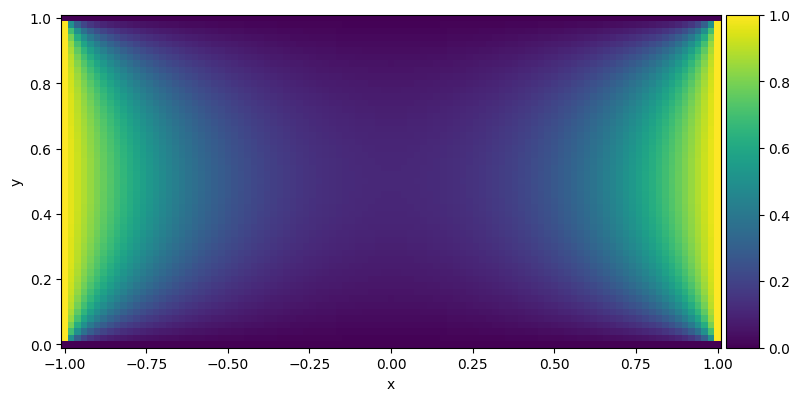

In [6]:
fig=plt.figure(figsize=(9,8))
ax=fig.add_subplot(111)
im=plt.pcolormesh(x,y,V)
ax.set_aspect('equal')
plt.xlabel("x")
plt.ylabel("y")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

You can also show V in a 3D plot where $z=V(x,y)$ is the height of the surface. Below we use `k3d` to make the ineractive 3D plot.

In [7]:
import k3d
from k3d.colormaps import matplotlib_color_maps

In [8]:
plt_surface = k3d.surface(V,
                          xmin=x0[0], xmax=x0[-1],
                          ymin=y0[0], ymax=y0[-1],
                          # wireframe=True,
                          # compression_level=9,
                          color_map=matplotlib_color_maps.Coolwarm,
                          attribute=V, color_range=[np.amin(V), np.amax(V)])


plot = k3d.plot()
plot += plt_surface
plot.display()

/Users/yajieyuan/Library/Python/3.9/lib/python/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Output()

## Exercise: Laplace's equation in 2D Cartesian coordinates

Let's consider the domain $0\le x\le a$ and $0\le y\le b$. In the domain there is no charge so the electric potential satisfies Laplace's equation,
$$\frac{\partial^2 V}{\partial x^2}+\frac{\partial^2 V}{\partial y^2}=0,$$
and the boundary conditions are
$$V(x,y=0)=V_0\sin\left(2\pi \frac{x}{a}\right),$$
$$V(x,y=b)=0,$$
$$V(x=0,y)=0,$$
$$V(x=a,y)=0.$$
Write your own code to solve the problem numerically and plot out your solution. To be concrete, you can set $a=1$, $b=1$, $V_0=1$. 
This problem can be solved analytically. Obtain the analytical solution and compare your numerical solution with it. Experiment with different convergence criteria (`eps` in the example code) and grid resolution (`dx` in the example code) to see how the error depends on these numerical settings.

Now, change the $y=0$ boundary condition to $V(x,y=0)=V_0$ (constant potential). What result do you get?

### Solution

The following code solves the problem numerically and plot out the solution.

In [30]:
a=1.0
b=1.0
V0=1.0

dx=1.0/50

xmin=0
xmax=a
ymin=0
ymax=b

nx=int((xmax-xmin)/dx)
ny=int((ymax-ymin)/dx)


x0=np.linspace(xmin,xmax,nx+1)
y0=np.linspace(ymin,ymax,ny+1)

x,y=np.meshgrid(x0,y0)

# Initial guess for the solution
V=np.zeros_like(x)

# Apply boundary conditions
V[:,0]=0 # x=0
V[:,-1]=0 # x=a
V[0,:]=V0*np.sin(2.0*np.pi*x0/a) # y=0
V[-1,:]=0 # y=b

eps=1.0e-6

V1=np.copy(V)
V1[1:-1,1:-1]=0.25*(V[0:-2,1:-1]+V[2:,1:-1]+V[1:-1,0:-2]+V[1:-1,2:])
resid=np.sum(np.fabs(V1-V))
V=np.copy(V1)

start=time.time()
it=0
while (resid>eps):
    V1[1:-1,1:-1]=0.25*(V[0:-2,1:-1]+V[2:,1:-1]+V[1:-1,0:-2]+V[1:-1,2:])
    resid=np.sum(np.fabs(V1-V))
    V=np.copy(V1)
    it=it+1
end=time.time()
print("Number of iterations:",it)
print("The time spent is",end-start,"s")

Number of iterations: 2704
The time spent is 0.04555201530456543 s


The following is a 2D color plot of V.

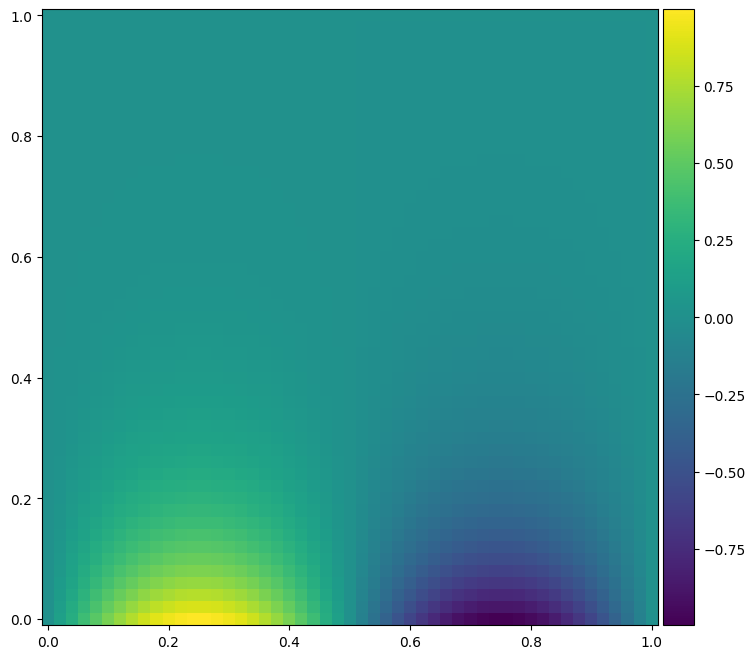

In [31]:
fig=plt.figure(figsize=(9,8))
ax=fig.add_subplot(111)
im=plt.pcolormesh(x,y,V)
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

The following shows V in a 3D plot where $z=V(x,y)$ is the height of the surface.

In [ ]:
import k3d
from k3d.colormaps import matplotlib_color_maps

In [32]:
plt_surface = k3d.surface(V,
                          xmin=x0[0], xmax=x0[-1],
                          ymin=y0[0], ymax=y0[-1],
                          # wireframe=True,
                          # compression_level=9,
                          color_map=matplotlib_color_maps.Coolwarm,
                          attribute=V, color_range=[np.amin(V), np.amax(V)])


plot = k3d.plot()
plot += plt_surface
plot.display()

Output()

The problem can be solved analytically. We use separation of variables, assuming that the solution takes the form $V(x,y)=X(x)Y(y)$. Plugging this into the Laplace equation, we get
$$\frac{d^2X}{dx^2}Y+X\frac{d^2Y}{dy^2}=0$$
Dividing both sides by $V(x,y)$, we get
$$\frac{1}{X}\frac{d^2X}{dx^2}+\frac{1}{Y}\frac{d^2Y}{dy^2}=0$$
The first term is a function of $x$, and the second term is a function of $y$. For the equation to hold, we need 
$$\frac{d^2X}{dx^2}=-k^2X,\quad \frac{d^2Y}{dy^2}=k^2Y.$$
For this particular problem, we have set the sign of the constants as above because this makes it easier to write down the solution.
The general solutions for $X(x)$ and $Y(y)$ are the following:
$$X(x)=A \sin(kx)+B\cos(kx),\quad Y(y)=C\sinh(ky)+D\cosh(ky).$$
So
$$V(x,y)=X(x)Y(y)=[A \sin(kx)+B\cos(kx)][C\sinh(ky)+D\cosh(ky)].$$
Now we apply the boundary conditions.
- $V(x=0,y)=0$ requires $B=0$. We can absorb A into C and D, so $V(x,y)=\sin(kx)[C\sinh(ky)+D\cosh(ky)].$
- $V(x=a,y)=0$ requires $\sin(ka)=0$, so $k=n\pi/a$, $n=1,2,3,\ldots$
- $V(x,y=b)=0$ requires $C\sinh(kb)+D\cosh(kb)=0$, so $D=-C\sinh(kb)/\cosh(kb)=-C\tanh(kb)$.

In summary, with the constraint of the three boundary conditions, the separable solutions can be written as
$$V_n(x,y)=C_n\sin\frac{n\pi x}{a}\left(\sinh\frac{n\pi y}{a}-\tanh\frac{n\pi b}{a}\cosh\frac{n\pi y}{a}\right)\quad n=1,2,3,\ldots$$
And the general solution can be written as a linear combination of all the $V_n$'s
$$V(x,y)=\sum_{n=1}^{\infty}V_n(x,y)=\sum_{n=1}^{\infty}C_n\sin\frac{n\pi x}{a}\left(\sinh\frac{n\pi y}{a}-\tanh\frac{n\pi b}{a}\cosh\frac{n\pi y}{a}\right)$$
To satisfy the last boundary condition $V(x,y=0)=V_0\sin\left(2\pi \frac{x}{a}\right)$, we use the fact that the sine series are complete and orthogonal, so only one term with $n=2$ should be present, and the coefficient should satisfy
$$C_2=-V_0\coth\frac{2\pi b}{a}.$$
So we get the final solution
$$V(x,y)=V_0\sin\frac{2\pi x}{a}\left(\cosh\frac{2\pi y}{a}-\sinh\frac{2\pi y}{a}\coth\frac{2\pi b}{a}\right)=V_0\sin\frac{2\pi x}{a}\sinh\frac{2\pi(b-y)}{a}/\sinh\frac{2\pi b}{a}.$$

The following code calculates the maximum difference between the numerical solution and the true solution, and plot out the distribution of the errors on the grid.

Maximum error  0.00048229684894196545


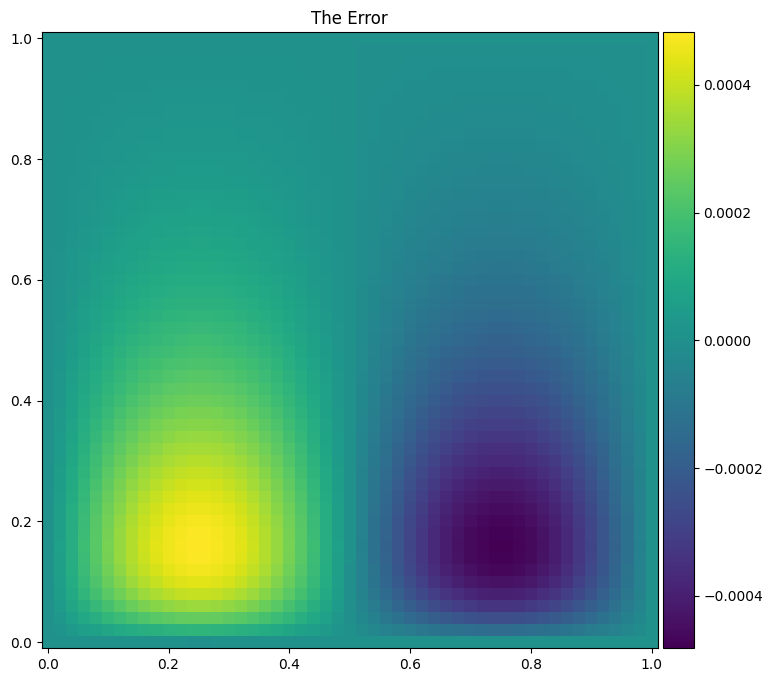

In [7]:
Va=V0*np.sin(2.0*np.pi*x/a)*np.sinh(2.0*np.pi*(b-y)/a)/np.sinh(2.0*np.pi*b/a)
diff=V-Va
print("Maximum error ",np.amax(np.fabs(diff)))
fig=plt.figure(figsize=(9,8))
ax=fig.add_subplot(111)
im=plt.pcolormesh(x,y,diff)
ax.set_aspect('equal')
plt.title('The Error')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

In what follows, we check how the error depends on the tolerance level, at a fixed grid resolution.

In [13]:
a=1.0
b=1.0
V0=1.0

dx=1.0/50

xmin=0
xmax=a
ymin=0
ymax=b

nx=int((xmax-xmin)/dx)
ny=int((ymax-ymin)/dx)


x0=np.linspace(xmin,xmax,nx+1)
y0=np.linspace(ymin,ymax,ny+1)

x,y=np.meshgrid(x0,y0)

# analytical solution
Va=V0*np.sin(2.0*np.pi*x/a)*np.sinh(2.0*np.pi*(b-y)/a)/np.sinh(2.0*np.pi*b/a)

epss=[1e-2,1e-3,1e-4,1e-5,1.0e-6,1e-7]
errors=[]

# Solve the equation at different tolerance eps
for eps in epss:
    # Initial guess for the solution
    V=np.zeros_like(x)

    # Apply boundary conditions
    V[:,0]=0 # x=0
    V[:,-1]=0 # x=a
    V[0,:]=V0*np.sin(2.0*np.pi*x0/a) # y=0
    V[-1,:]=0 # y=b

    V1=np.copy(V)
    V1[1:-1,1:-1]=0.25*(V[0:-2,1:-1]+V[2:,1:-1]+V[1:-1,0:-2]+V[1:-1,2:])
    resid=np.sum(np.fabs(V1-V))
    V=np.copy(V1)

    start=time.time()
    it=0
    while (resid>eps):
        V1[1:-1,1:-1]=0.25*(V[0:-2,1:-1]+V[2:,1:-1]+V[1:-1,0:-2]+V[1:-1,2:])
        resid=np.sum(np.fabs(V1-V))
        V=np.copy(V1)
        it=it+1
    end=time.time()
    print("The tolerance is eps=",eps)
    print("Number of iterations:",it)
    print("The time spent is",end-start,"s")
    diff=V-Va
    error=np.amax(np.fabs(diff))
    print("Maximum error ",error)
    errors.append(error)

The tolerance is eps= 0.01
Number of iterations: 841
The time spent is 0.018837928771972656 s
Maximum error  0.00180819611962562
The tolerance is eps= 0.001
Number of iterations: 1307
The time spent is 0.024702072143554688 s
Maximum error  0.00039028165844207097
The tolerance is eps= 0.0001
Number of iterations: 1773
The time spent is 0.029753923416137695 s
Maximum error  0.0004727368607638227
The tolerance is eps= 1e-05
Number of iterations: 2239
The time spent is 0.034822940826416016 s
Maximum error  0.0004814353877729549
The tolerance is eps= 1e-06
Number of iterations: 2704
The time spent is 0.04154205322265625 s
Maximum error  0.00048229684894196545
The tolerance is eps= 1e-07
Number of iterations: 3170
The time spent is 0.04765582084655762 s
Maximum error  0.00048238326153920985


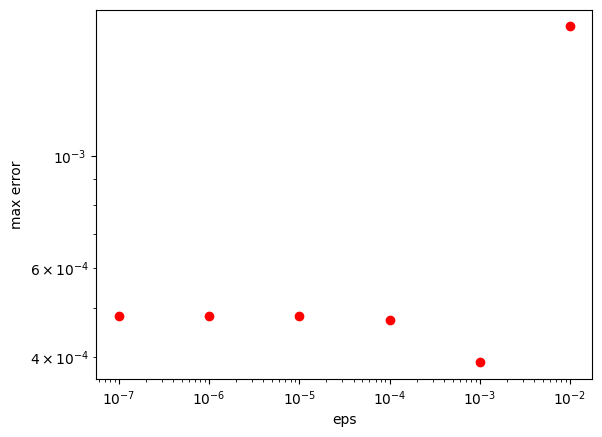

In [14]:
plt.plot(epss,errors,'ro')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('eps')
plt.ylabel('max error')
plt.show()

We carry out the same comparison again at a different grid resolution. This time `dx` is half of the previous value.

In [15]:
a=1.0
b=1.0
V0=1.0

dx=1.0/100

xmin=0
xmax=a
ymin=0
ymax=b

nx=int((xmax-xmin)/dx)
ny=int((ymax-ymin)/dx)


x0=np.linspace(xmin,xmax,nx+1)
y0=np.linspace(ymin,ymax,ny+1)

x,y=np.meshgrid(x0,y0)

# analytical solution
Va=V0*np.sin(2.0*np.pi*x/a)*np.sinh(2.0*np.pi*(b-y)/a)/np.sinh(2.0*np.pi*b/a)

epss=[1e-2,1e-3,1e-4,1e-5,1.0e-6,1e-7]
errors1=[]

# Solve the equation at different tolerance eps
for eps in epss:
    # Initial guess for the solution
    V=np.zeros_like(x)

    # Apply boundary conditions
    V[:,0]=0 # x=0
    V[:,-1]=0 # x=a
    V[0,:]=V0*np.sin(2.0*np.pi*x0/a) # y=0
    V[-1,:]=0 # y=b

    V1=np.copy(V)
    V1[1:-1,1:-1]=0.25*(V[0:-2,1:-1]+V[2:,1:-1]+V[1:-1,0:-2]+V[1:-1,2:])
    resid=np.sum(np.fabs(V1-V))
    V=np.copy(V1)

    start=time.time()
    it=0
    while (resid>eps):
        V1[1:-1,1:-1]=0.25*(V[0:-2,1:-1]+V[2:,1:-1]+V[1:-1,0:-2]+V[1:-1,2:])
        resid=np.sum(np.fabs(V1-V))
        V=np.copy(V1)
        it=it+1
    end=time.time()
    print("The tolerance is eps=",eps)
    print("Number of iterations:",it)
    print("The time spent is",end-start,"s")
    diff=V-Va
    error=np.amax(np.fabs(diff))
    print("Maximum error ",error)
    errors1.append(error)

The tolerance is eps= 0.01
Number of iterations: 3367
The time spent is 0.17459392547607422 s
Maximum error  0.0019758273835654636
The tolerance is eps= 0.001
Number of iterations: 5231
The time spent is 0.2807948589324951 s
Maximum error  0.00016046291240110616
The tolerance is eps= 0.0001
Number of iterations: 7097
The time spent is 0.3495969772338867 s
Maximum error  0.00011157365726888191
The tolerance is eps= 1e-05
Number of iterations: 8963
The time spent is 0.4536397457122803 s
Maximum error  0.00011999038025528597
The tolerance is eps= 1e-06
Number of iterations: 10829
The time spent is 0.5326340198516846 s
Maximum error  0.00012085923038629431
The tolerance is eps= 1e-07
Number of iterations: 12695
The time spent is 0.6364710330963135 s
Maximum error  0.00012094589087596752


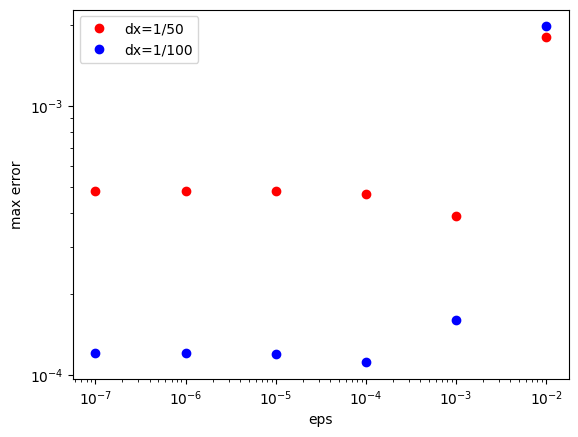

In [16]:
plt.plot(epss,errors,'ro',label='dx=1/50')
plt.plot(epss,errors1,'bo',label='dx=1/100')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('eps')
plt.ylabel('max error')
plt.legend(loc=0)
plt.show()

You can see that reducing the tolerance level does not help beyond some point (when eps<1e-4 in this example). The grid resolution is more important in determining the error in the numerical solution. In what follows we show how the error depends on the grid resolution, at a fixed `eps`.

In [21]:
a=1.0
b=1.0
V0=1.0

xmin=0
xmax=a
ymin=0
ymax=b

eps=1.0e-5
MaxIter=100000

dxs=[1.0/20,1.0/50,1.0/100,1.0/200]
errors2=[]

# Solve the equation at different grid resolution
for dx in dxs:

    nx=int((xmax-xmin)/dx)
    ny=int((ymax-ymin)/dx)


    x0=np.linspace(xmin,xmax,nx+1)
    y0=np.linspace(ymin,ymax,ny+1)

    x,y=np.meshgrid(x0,y0)

    # Initial guess for the solution
    V=np.zeros_like(x)

    # Apply boundary conditions
    V[:,0]=0 # x=0
    V[:,-1]=0 # x=a
    V[0,:]=V0*np.sin(2.0*np.pi*x0/a) # y=0
    V[-1,:]=0 # y=b

    V1=np.copy(V)
    V1[1:-1,1:-1]=0.25*(V[0:-2,1:-1]+V[2:,1:-1]+V[1:-1,0:-2]+V[1:-1,2:])
    resid=np.sum(np.fabs(V1-V))
    V=np.copy(V1)

    start=time.time()
    it=0
    while (resid>eps and it<MaxIter):
        V1[1:-1,1:-1]=0.25*(V[0:-2,1:-1]+V[2:,1:-1]+V[1:-1,0:-2]+V[1:-1,2:])
        resid=np.sum(np.fabs(V1-V))
        V=np.copy(V1)
        it=it+1
    end=time.time()
    print("The grid cell size is dx=",dx)
    print("Number of iterations:",it)
    print("The time spent is",end-start,"s")
    
    # analytical solution
    Va=V0*np.sin(2.0*np.pi*x/a)*np.sinh(2.0*np.pi*(b-y)/a)/np.sinh(2.0*np.pi*b/a)
    diff=V-Va
    error=np.amax(np.fabs(diff))
    print("Maximum error ",error)
    errors2.append(error)

The grid cell size is dx= 0.05
Number of iterations: 356
The time spent is 0.0058498382568359375 s
Maximum error  0.0029937502724883824
The grid cell size is dx= 0.02
Number of iterations: 2239
The time spent is 0.038522958755493164 s
Maximum error  0.0004814353877729549
The grid cell size is dx= 0.01
Number of iterations: 8963
The time spent is 0.48696088790893555 s
Maximum error  0.00011999038025528597
The grid cell size is dx= 0.005
Number of iterations: 35861
The time spent is 5.202432870864868 s
Maximum error  2.9298236844055303e-05


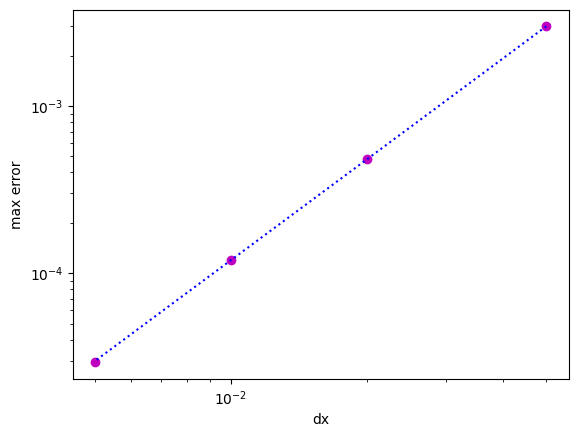

In [25]:
plt.plot(dxs,errors2,'mo')
plt.plot(dxs,errors2[0]*(np.asarray(dxs)/dxs[0])**2,'b:')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('dx')
plt.ylabel('max error')
plt.show()

In the plot, the magenta dots are the errors measured from the simulation, and the blue dotted line is $\propto dx^2$. You can see that the errors go down as $dx^2$ when we reduce $dx$. This is a second order scheme. It is as expected, since we use second order accurate finite difference in writing the discretized version of the equation.

Now we will look at the case with a different boundary condition at $y=0$, $V(x,y=0)=V_0$.

In [26]:
a=1.0
b=1.0
V0=1.0

dx=1.0/50

xmin=0
xmax=a
ymin=0
ymax=b

nx=int((xmax-xmin)/dx)
ny=int((ymax-ymin)/dx)


x0=np.linspace(xmin,xmax,nx+1)
y0=np.linspace(ymin,ymax,ny+1)

x,y=np.meshgrid(x0,y0)

# Initial guess for the solution
V=np.zeros_like(x)

# Apply boundary conditions
V[:,0]=0 # x=0
V[:,-1]=0 # x=a
V[0,:]=V0 # y=0
V[-1,:]=0 # y=b

eps=1.0e-6

V1=np.copy(V)
V1[1:-1,1:-1]=0.25*(V[0:-2,1:-1]+V[2:,1:-1]+V[1:-1,0:-2]+V[1:-1,2:])
resid=np.sum(np.fabs(V1-V))
V=np.copy(V1)

start=time.time()
it=0
while (resid>eps):
    V1[1:-1,1:-1]=0.25*(V[0:-2,1:-1]+V[2:,1:-1]+V[1:-1,0:-2]+V[1:-1,2:])
    resid=np.sum(np.fabs(V1-V))
    V=np.copy(V1)
    it=it+1
end=time.time()
print("Number of iterations:",it)
print("The time spent is",end-start,"s")

Number of iterations: 6888
The time spent is 0.11175203323364258 s


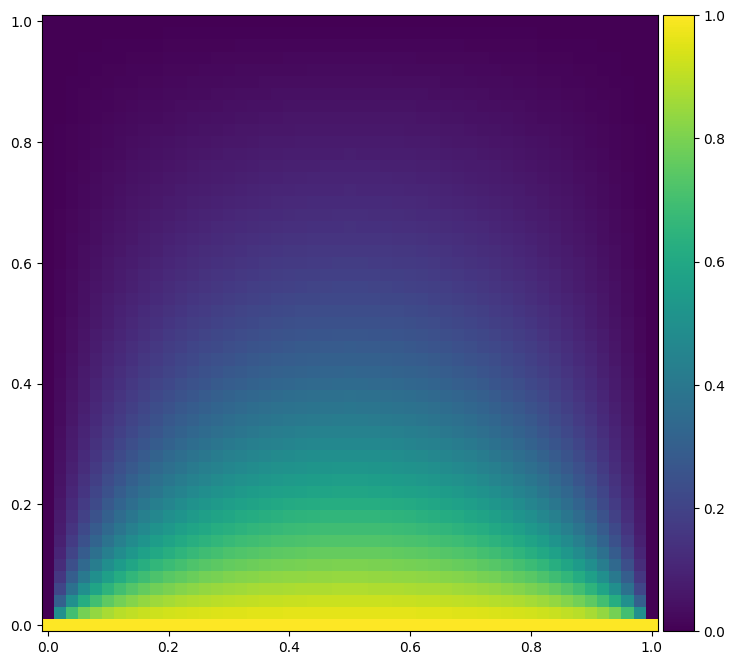

In [27]:
fig=plt.figure(figsize=(9,8))
ax=fig.add_subplot(111)
im=plt.pcolormesh(x,y,V)
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

The following 3D plot shows the potential as a height above the xy plane.

In [28]:
import k3d
from k3d.colormaps import matplotlib_color_maps

In [29]:
plt_surface = k3d.surface(V,
                          xmin=x0[0], xmax=x0[-1],
                          ymin=y0[0], ymax=y0[-1],
                          # wireframe=True,
                          # compression_level=9,
                          color_map=matplotlib_color_maps.Coolwarm,
                          attribute=V, color_range=[np.amin(V), np.amax(V)])


plot = k3d.plot()
plot += plt_surface
plot.display()

/Users/yajieyuan/Library/Python/3.9/lib/python/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Output()

## 3D Example

In 3D, the Jacobi's relaxation method can be generalized to
$$V_{i,j,k}^{n+1}=\frac{1}{6}(V_{i-1,j,k}^n+V_{i+1,jk}^n+V_{i,j-1,k}^n+V_{i,j+1,k}^n+V_{i,j,k-1}^n+V_{i,j,k+1}^n).\qquad (**)$$

Let's look at the following example. Consider the domain $0\le x\le a$, $0\le y\le b$, $0\le z\le c$. In the domain there is no charge,
$$\frac{\partial^2 V}{\partial x^2}+\frac{\partial^2 V}{\partial y^2}+\frac{\partial^2 V}{\partial z^2}=0,$$
and the boundary conditions are
$$V(x=0,y,z)=V_0\sin\left(2\pi\frac{y}{b}\right)\sin\left(2\pi\frac{z}{c}\right),$$
$$V(x=a,y,z)=0.$$
$$V(x,y=0,z)=V_1\sin\left(2\pi \frac{x}{a}\right),$$
$$V(x,y=b,z)=0,$$
$$V(x,y,z=0)=0,$$
$$V(x,y,z=c)=0,$$

The following is an example code to solve the differential equation using the Jacobi's relaxation method in 3D. Note that the indexing below is such that `V[k,j,i]` denotes the value of V at the grid point that is the i-th in the x direction, j-th in the y direction, and k-th in the z direction.

In [9]:
a=1.0
b=2.0
c=3.0
V0=1.0
V1=2.0

dx=1.0/50
dy=dx
dz=dx

nx=int(a/dx)
ny=int(b/dy)
nz=int(c/dz)

x0=np.linspace(0.0,a,nx+1)
y0=np.linspace(0.0,b,ny+1)
z0=np.linspace(0.0,c,nz+1)

x,y,z=np.meshgrid(x0,y0,z0)
print(x.shape)

x=np.transpose(x,(2,0,1))
y=np.transpose(y,(2,0,1))
z=np.transpose(z,(2,0,1))
print(x.shape)

# Initial guess for the solution
V=np.zeros_like(x)

# Apply boundary conditions
V[:,:,0]=V0*np.sin(2.0*np.pi*y[:,:,0]/b)*np.sin(2.0*np.pi*z[:,:,0]/c) # x=0
V[:,:,-1]=0 # x=a
V[:,0,:]=V1*np.sin(2.0*np.pi*x[:,0,:]/a) # y=0
V[:,-1,:]=0 # y=b
V[0,:,:]=0 # z=0
V[-1,:,:]=0 # z=c

eps=1.0e-6

V1=np.copy(V)
V1[1:-1,1:-1,1:-1]=1.0/6.0*(V[0:-2,1:-1,1:-1]+V[2:,1:-1,1:-1]+V[1:-1,0:-2,1:-1]+V[1:-1,2:,1:-1]+V[1:-1,1:-1,0:-2]+V[1:-1,1:-1,2:])
resid=np.sum(np.fabs(V1-V)) # calculate the initial residual
resid0=resid
V=np.copy(V1)

start=time.time()
it=0
while (resid/resid0>eps):
    V1[1:-1,1:-1,1:-1]=1.0/6.0*(V[0:-2,1:-1,1:-1]+V[2:,1:-1,1:-1]+V[1:-1,0:-2,1:-1]+V[1:-1,2:,1:-1]+V[1:-1,1:-1,0:-2]+V[1:-1,1:-1,2:])
    resid=np.sum(np.fabs(V1-V))
    V=np.copy(V1)
    it=it+1
end=time.time()
print("Number of iterations:",it)
print("The time spent is",end-start,"s")

(101, 51, 151)
(151, 101, 51)
Number of iterations: 6432
The time spent is 30.872147798538208 s


The following plot is a slice on the $z=1.5$ plane.

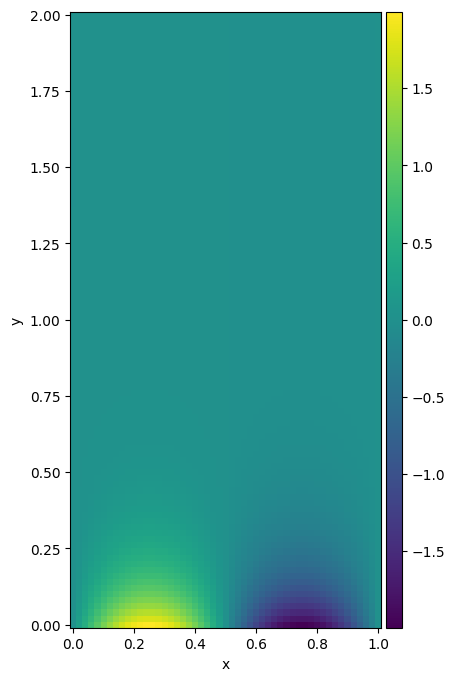

In [10]:
fig=plt.figure(figsize=(9,8))
ax=fig.add_subplot(111)
im=plt.pcolormesh(x0,y0,V[nz//2])
ax.set_aspect('equal')
plt.xlabel("x")
plt.ylabel("y")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

The following plot shows the boundary condition at $x=0$:

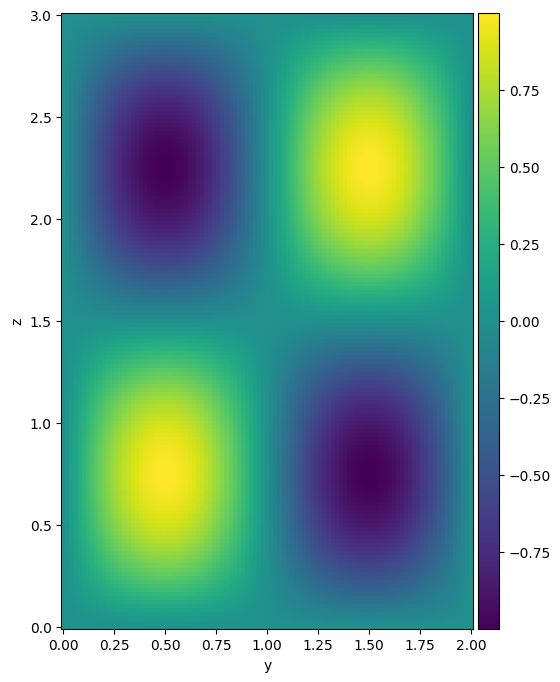

In [11]:
fig=plt.figure(figsize=(9,8))
ax=fig.add_subplot(111)
im=plt.pcolormesh(y0,z0,V[:,:,0])
ax.set_aspect('equal')
plt.xlabel("y")
plt.ylabel("z")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

The following plot shows a slice on the $x=0.24$ plane:

x= 0.24


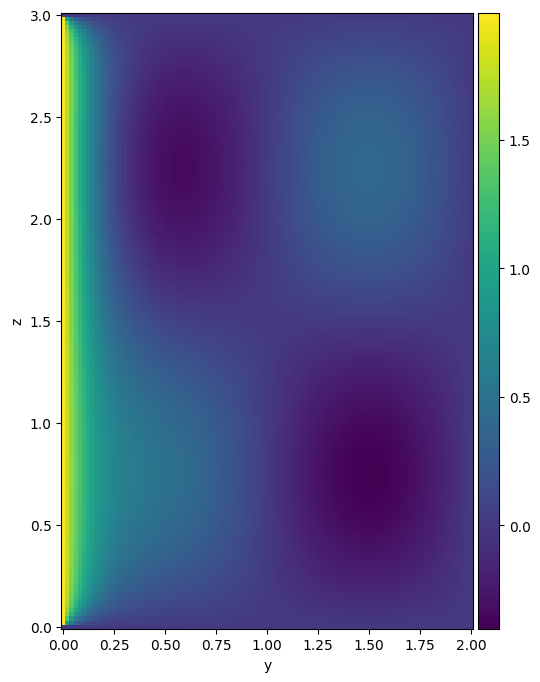

In [12]:
print('x=',x0[nx//4])
fig=plt.figure(figsize=(9,8))
ax=fig.add_subplot(111)
im=plt.pcolormesh(y0,z0,V[:,:,nx//4])
ax.set_aspect('equal')
plt.xlabel("y")
plt.ylabel("z")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

The following plot shows a slice on the $x=0.5$ plane:

x= 0.5


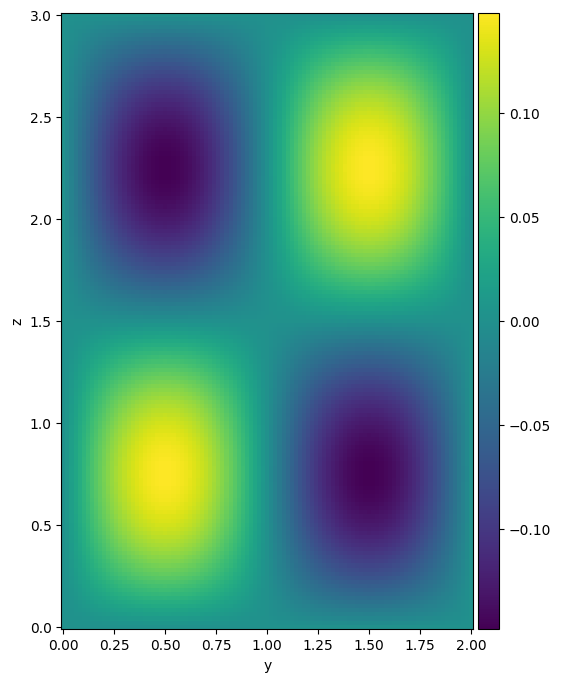

In [13]:
print('x=',x0[nx//2])
fig=plt.figure(figsize=(9,8))
ax=fig.add_subplot(111)
im=plt.pcolormesh(y0,z0,V[:,:,nx//2])
ax.set_aspect('equal')
plt.xlabel("y")
plt.ylabel("z")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

3D plot showing a few isosurfaces of V. Green surface has $V=0$, yellow surface has $V=0.5$, and blue surface has $V=-0.5$.

In [14]:
import k3d
plt_marching1 = k3d.marching_cubes(V, level=0.0,
                                  color=0x008000, # green
                                  opacity=0.25,
                                  xmin=np.amin(x0), xmax=np.amax(x0),
                                  ymin=np.amin(y0), ymax=np.amax(y0),
                                  zmin=np.amin(z0), zmax=np.amax(z0),
                                  compression_level=9,
                                  flat_shading=False)
plt_marching2 = k3d.marching_cubes(V, level=0.5,
                                  color=0xFFFF00, # yellow
                                  opacity=0.25,
                                  xmin=np.amin(x0), xmax=np.amax(x0),
                                  ymin=np.amin(y0), ymax=np.amax(y0),
                                  zmin=np.amin(z0), zmax=np.amax(z0),
                                  compression_level=9,
                                  flat_shading=False)
plt_marching3 = k3d.marching_cubes(V, level=-0.5,
                                  color=0x0000FF, # blue
                                  opacity=0.25,
                                  xmin=np.amin(x0), xmax=np.amax(x0),
                                  ymin=np.amin(y0), ymax=np.amax(y0),
                                  zmin=np.amin(z0), zmax=np.amax(z0),
                                  compression_level=9,
                                  flat_shading=False)


plot = k3d.plot()
plot += plt_marching1
plot += plt_marching2
plot += plt_marching3
plot.display()

Output()

## Exercise: Laplace's equation in 3D Cartesian coordinates

Consider the domain $0\le x\le a$, $0\le y\le b$, $0\le z\le c$. In the domain there is no charge,
$$\frac{\partial^2 V}{\partial x^2}+\frac{\partial^2 V}{\partial y^2}+\frac{\partial^2 V}{\partial z^2}=0,$$
and the boundary conditions are
$$V(x=0,y,z)=V_0\frac{y}{b}\left(1-\frac{y}{b}\right)\frac{z}{c}\left(1-\frac{z}{c}\right),$$
$$V(x=a,y,z)=V_1,$$
$$V(x,y=0,z)=0,$$
$$V(x,y=b,z)=0,$$
$$V(x,y,z=0)=0,$$
$$V(x,y,z=c)=0,$$
Namely, the potentials at $x=0$ and $x=a$ are maintained at specific values while on the other four faces the potential is zero.
Write your own code to solve the problem numerically and plot out your solution. To be concrete, you can set $a=1$, $b=1$, $c=1$, $V_0=2$, $V_1=-1$.

### Solution

In [33]:
a=1.0
b=1.0
c=1.0
V0=2.0
V1=-1.0

dx=1.0/50
dy=dx
dz=dx

nx=int(a/dx)
ny=int(b/dy)
nz=int(c/dz)

x0=np.linspace(0.0,a,nx+1)
y0=np.linspace(0.0,b,ny+1)
z0=np.linspace(0.0,c,nz+1)

x,y,z=np.meshgrid(x0,y0,z0)
print(x.shape)

x=np.transpose(x,(2,0,1))
y=np.transpose(y,(2,0,1))
z=np.transpose(z,(2,0,1))
print(x.shape)

# Initial guess for the solution
V=np.zeros_like(x)

# Apply boundary conditions
V[:,:,0]=V0*y[:,:,0]/b*(1.0-y[:,:,0]/b)*z[:,:,0]/c*(1.0-z[:,:,0]/c) # x=0
V[:,:,-1]=V1 # x=a
V[:,0,:]=0 # y=0
V[:,-1,:]=0 # y=b
V[0,:,:]=0 # z=0
V[-1,:,:]=0 # z=c

eps=1.0e-6

V1=np.copy(V)
V1[1:-1,1:-1,1:-1]=1.0/6.0*(V[0:-2,1:-1,1:-1]+V[2:,1:-1,1:-1]+V[1:-1,0:-2,1:-1]+V[1:-1,2:,1:-1]+V[1:-1,1:-1,0:-2]+V[1:-1,1:-1,2:])
resid=np.sum(np.fabs(V1-V))
V=np.copy(V1)

start=time.time()
it=0
while (resid>eps):
    V1[1:-1,1:-1,1:-1]=1.0/6.0*(V[0:-2,1:-1,1:-1]+V[2:,1:-1,1:-1]+V[1:-1,0:-2,1:-1]+V[1:-1,2:,1:-1]+V[1:-1,1:-1,0:-2]+V[1:-1,1:-1,2:])
    resid=np.sum(np.fabs(V1-V))
    V=np.copy(V1)
    it=it+1
end=time.time()
print("Number of iterations:",it)
print("The time spent is",end-start,"s")

(51, 51, 51)
(51, 51, 51)
Number of iterations: 8513
The time spent is 6.037069082260132 s


In [37]:
print('Maximum of V:',np.amax(V))
print('Minimum of V:',np.amin(V))

Maximum of V: 0.125
Minimum of V: -1.0


The following plot shows the boundary condition at $x=0$.

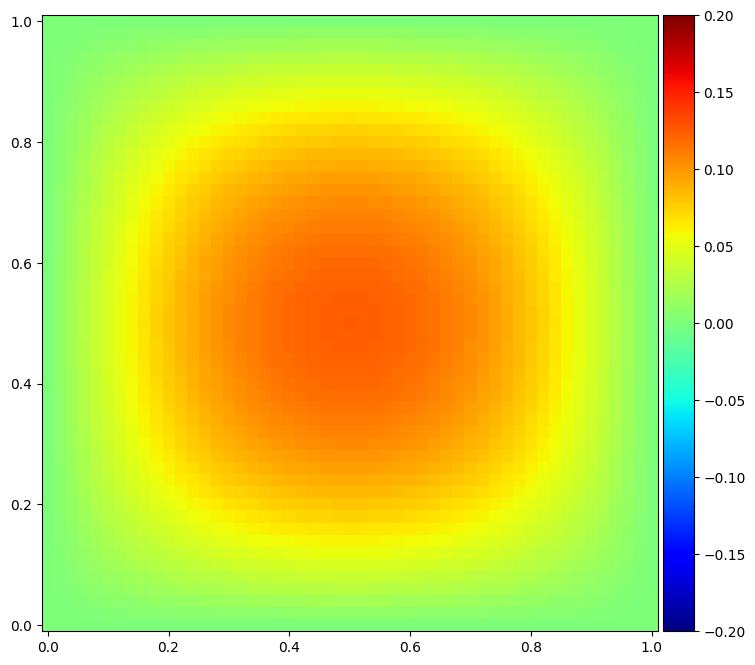

In [34]:
fig=plt.figure(figsize=(9,8))
ax=fig.add_subplot(111)
im=plt.pcolormesh(y0,z0,V[:,:,0],vmin=-0.2,vmax=0.2,cmap='jet')
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

The following plot shows a slice on the $x=0.5$ plane:

x= 0.5


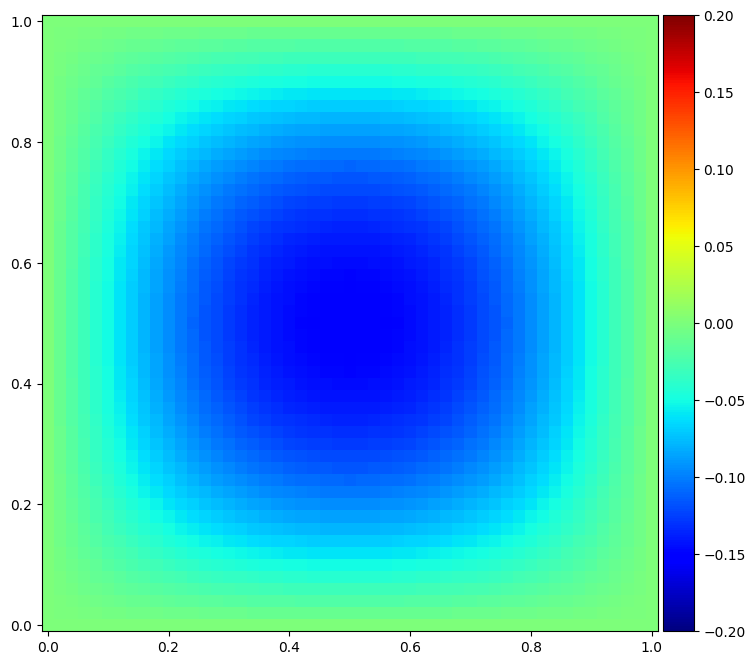

In [35]:
print('x=',x0[nx//2])
fig=plt.figure(figsize=(9,8))
ax=fig.add_subplot(111)
im=plt.pcolormesh(y0,z0,V[:,:,nx//2],vmin=-0.2,vmax=0.2,cmap='jet')
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

3D plot showing a few isosurfaces of V. Green surface has $V=0$, yellow surface has $V=0.1$, and blue surface has $V=-0.1$.

In [36]:
import k3d
plt_marching1 = k3d.marching_cubes(V, level=0.0,
                                  color=0x008000, # green
                                  opacity=0.25,
                                  xmin=np.amin(x0), xmax=np.amax(x0),
                                  ymin=np.amin(y0), ymax=np.amax(y0),
                                  zmin=np.amin(z0), zmax=np.amax(z0),
                                  compression_level=9,
                                  flat_shading=False)
plt_marching2 = k3d.marching_cubes(V, level=0.1,
                                  color=0xFFFF00, # yellow
                                  opacity=0.25,
                                  xmin=np.amin(x0), xmax=np.amax(x0),
                                  ymin=np.amin(y0), ymax=np.amax(y0),
                                  zmin=np.amin(z0), zmax=np.amax(z0),
                                  compression_level=9,
                                  flat_shading=False)
plt_marching3 = k3d.marching_cubes(V, level=-0.1,
                                  color=0x0000FF, # blue
                                  opacity=0.25,
                                  xmin=np.amin(x0), xmax=np.amax(x0),
                                  ymin=np.amin(y0), ymax=np.amax(y0),
                                  zmin=np.amin(z0), zmax=np.amax(z0),
                                  compression_level=9,
                                  flat_shading=False)


plot = k3d.plot()
plot += plt_marching1
plot += plt_marching2
plot += plt_marching3
plot.display()

Output()